In [207]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from cycler import cycler
from matplotlib.ticker import FuncFormatter
from scipy.stats import chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data
data = {}
filenames = [filename for filename in os.listdir(os.getcwd()+"/Data") if '.csv' in filename]
for f in filenames:
    data[int(f.split('_')[0])] = pd.read_csv("Data/"+f)

## 1. Do more and more people from non computer science background become developers?

In [3]:
data[2017]['MajorUndergrad'].value_counts()

Computer science or software engineering                        21409
Computer engineering or electrical/electronics engineering       4364
Computer programming or Web development                          3883
Information technology, networking, or system administration     2140
A natural science                                                1865
A non-computer-focused engineering discipline                    1789
Mathematics or statistics                                        1648
Something else                                                   1060
A humanities discipline                                           901
A business discipline                                             900
Management information systems                                    654
Fine arts or performing arts                                      646
A social science                                                  633
I never declared a major                                          592
Psychology          

In [4]:
data[2018]['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          50336
Another engineering discipline (ex. civil, electrical, mechanical)        6945
Information systems, information technology, or system administration     6507
A natural science (ex. biology, chemistry, physics)                       3050
Mathematics or statistics                                                 2818
Web development or web design                                             2418
A business discipline (ex. accounting, finance, marketing)                1921
A humanities discipline (ex. literature, history, philosophy)             1590
A social science (ex. anthropology, psychology, political science)        1377
Fine arts or performing arts (ex. graphic design, music, studio art)      1135
I never declared a major                                                   693
A health science (ex. nursing, pharmacy, radiology)                        246
Name: UndergradMajor, dtype: int64

In [5]:
data[2019]['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          47214
Another engineering discipline (ex. civil, electrical, mechanical)        6222
Information systems, information technology, or system administration     5253
Web development or web design                                             3422
A natural science (ex. biology, chemistry, physics)                       3232
Mathematics or statistics                                                 2975
A business discipline (ex. accounting, finance, marketing)                1841
A humanities discipline (ex. literature, history, philosophy)             1571
A social science (ex. anthropology, psychology, political science)        1352
Fine arts or performing arts (ex. graphic design, music, studio art)      1233
I never declared a major                                                   976
A health science (ex. nursing, pharmacy, radiology)                        323
Name: UndergradMajor, dtype: int64

While looking at the data above, one can see that the undergrad majors in 2017 are somewhat different from the majors in 2018 and 2019. Therefore, I needed to convert the majors in 2017 to make them consistent across time.

In [6]:
mapping = {'Computer science, computer engineering, or software engineering': ['Computer science or software engineering'],
 'Another engineering discipline (ex. civil, electrical, mechanical)': ['Computer engineering or electrical/electronics engineering', 'A non-computer-focused engineering discipline'],
'Information systems, information technology, or system administration': ['Information technology, networking, or system administration', 'Management information systems'],
'Web development or web design':['Computer programming or Web development'], 
'A natural science (ex. biology, chemistry, physics)': ['A natural science'], 
'Mathematics or statistics':['Mathematics or statistics'],
'A business discipline (ex. accounting, finance, marketing)':['A business discipline'],
'A humanities discipline (ex. literature, history, philosophy)':['A humanities discipline'],
'A social science (ex. anthropology, psychology, political science)':['Psychology', 'A social science'],
'Fine arts or performing arts (ex. graphic design, music, studio art)':['Fine arts or performing arts'],
'I never declared a major':['I never declared a major'],
'A health science (ex. nursing, pharmacy, radiology)': ['A health science']}

In [7]:
def map_2017_major_to_2019(x):
    '''The function will map the undergrad major in 2017 to 2019
    
    Parameters:
        x: a string of undergrad major in 2017
    
    Returns:
        major: a string of undergrad major in 2019
    '''
    major=np.nan
    for k,v in mapping.items():
        if x in v:
            major=k
    return major

In [8]:
# Convert the majors in 2017 to 2019
data[2017]['UndergradMajor'] = data[2017]['MajorUndergrad'].apply(lambda x: map_2017_major_to_2019(x))

In [9]:
# Create a dataframe to compare the majors across time
major_by_year = pd.DataFrame()
for i in [2017, 2018, 2019]:
    year = pd.DataFrame(data[i]['UndergradMajor'].value_counts()).reset_index().rename(
        columns={'index':'UndergradMajor', 'UndergradMajor':i})
    if i == 2017:
        major_by_year = year
    else:
        major_by_year = pd.merge(major_by_year, year, on='UndergradMajor', how='left')

In [10]:
major_by_year.set_index('UndergradMajor')

,2017,2018,2019
UndergradMajor,,,
"Computer science, computer engineering, or software engineering",21409,50336,47214
"Another engineering discipline (ex. civil, electrical, mechanical)",6153,6945,6222
Web development or web design,3883,2418,3422
"Information systems, information technology, or system administration",2794,6507,5253
"A natural science (ex. biology, chemistry, physics)",1865,3050,3232
Mathematics or statistics,1648,2818,2975
"A humanities discipline (ex. literature, history, philosophy)",901,1590,1571
"A business discipline (ex. accounting, finance, marketing)",900,1921,1841
"A social science (ex. anthropology, psychology, political science)",848,1377,1352


In [11]:
major_by_year_pct = major_by_year.set_index('UndergradMajor').div(major_by_year.set_index('UndergradMajor').sum())

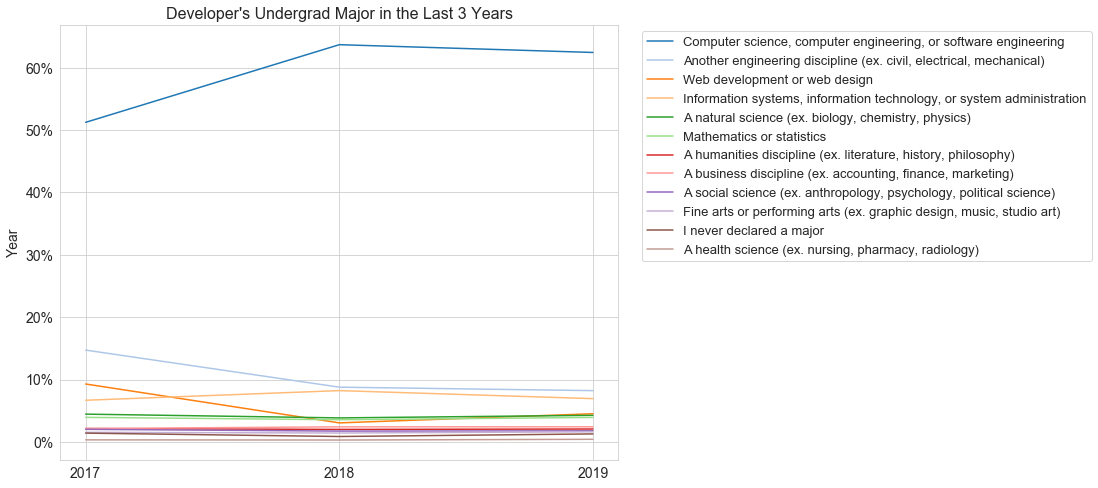

In [12]:
# Plot the trend of percentage of developers by undergrad major
sns.set_style("whitegrid")
pal = sns.color_palette(sns.color_palette("tab20"))
fig, ax = plt.subplots(figsize=(10,8))
ax.set_prop_cycle(cycler("color", pal.as_hex()))
for col in major_by_year_pct.T.columns:
    ax.plot(major_by_year_pct.T[col], label=col)
ax.set_xticks([2017, 2018, 2019])
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend(bbox_to_anchor=(1.03, 0.5, 0.5, 0.5), fontsize=13)
ax.set_title("Developer's Undergrad Major in the Last 3 Years", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Pct of the undergrad major", fontsize=14)
ax.set_ylabel("Year", fontsize=14)
plt.savefig("viz/undergrad_by_year", dpi=300, bbox_inches="tight")
plt.show()

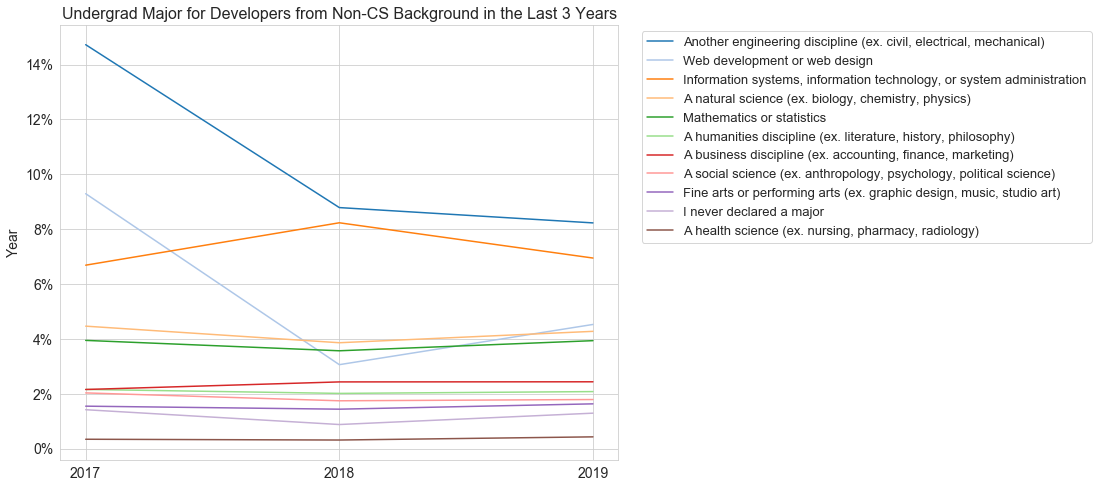

In [13]:
pal = sns.color_palette(sns.color_palette("tab20"))
fig, ax = plt.subplots(figsize=(10,8))
ax.set_prop_cycle(cycler("color", pal.as_hex()))
for col in major_by_year_pct.T.columns[1:]:
    ax.plot(major_by_year_pct.T[col], label=col)
ax.set_xticks([2017, 2018, 2019])
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.legend(bbox_to_anchor=(1.03, 0.5, 0.5, 0.5), fontsize=13)
ax.set_title("Undergrad Major for Developers from Non-CS Background in the Last 3 Years", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel("Pct of the undergrad major", fontsize=14)
ax.set_ylabel("Year", fontsize=14)
plt.savefig("viz/non_cs_undergrad_by_year", dpi=300, bbox_inches="tight")
plt.show()

## 2. Does gender affect whether a developer wants to become manager in the future?

In [14]:
data[2019]['MgrWant'].value_counts(dropna=False)

NaN                       27651
Not sure                  22276
No                        20383
Yes                       15565
I am already a manager     3008
Name: MgrWant, dtype: int64

In [15]:
data[2019]['Gender'].value_counts(dropna=False)

Man                                                            77919
Woman                                                           6344
NaN                                                             3477
Non-binary, genderqueer, or gender non-conforming                597
Man;Non-binary, genderqueer, or gender non-conforming            181
Woman;Non-binary, genderqueer, or gender non-conforming          163
Woman;Man                                                        132
Woman;Man;Non-binary, genderqueer, or gender non-conforming       70
Name: Gender, dtype: int64

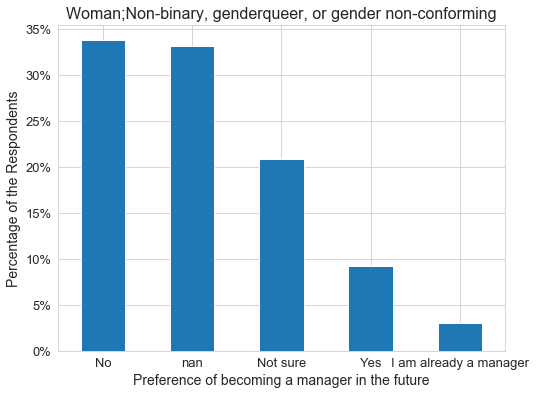

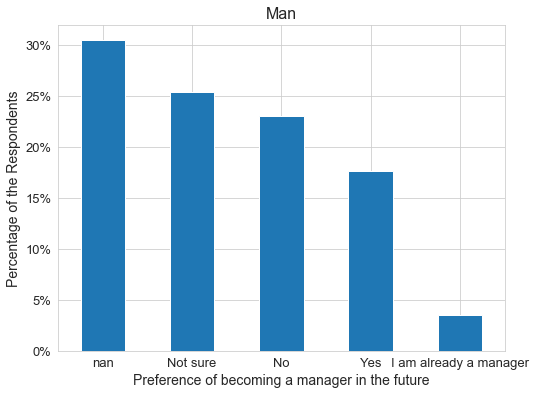

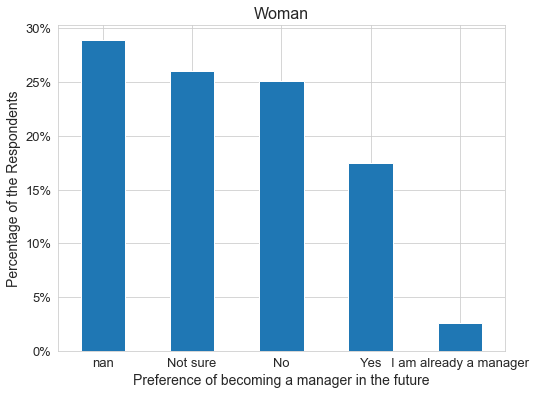

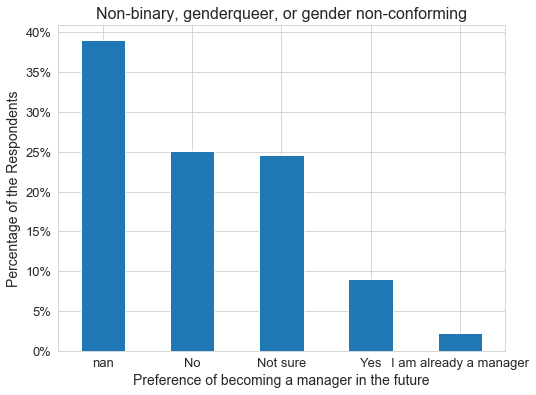

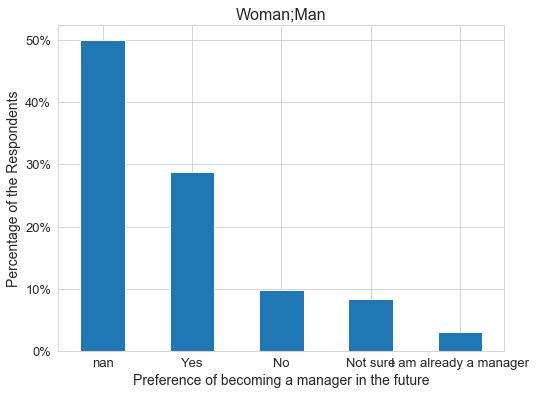

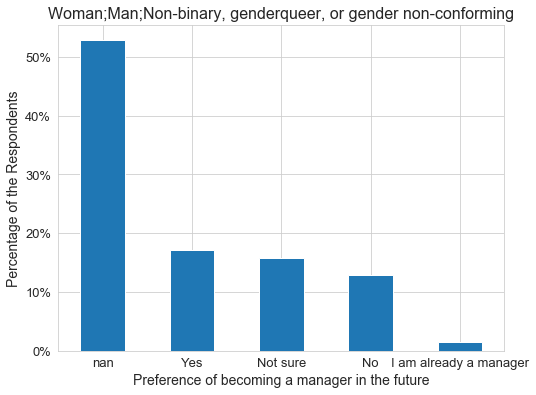

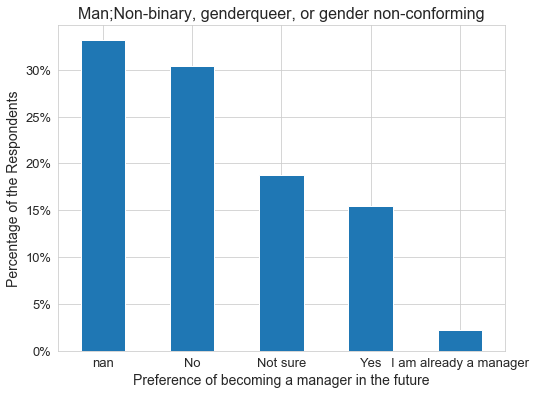

In [18]:
# Plot the preference of becoming a manager by gender
for i in list(set(data[2019]['Gender'])):
    if i is not np.nan: 
        fig, ax = plt.subplots(figsize=(8,6))
        (data[2019][data[2019]['Gender'] == i]['MgrWant'].value_counts(dropna=False)/data[2019][data[2019]['Gender'] == i]['MgrWant'].value_counts(dropna=False).sum()).plot.bar()
        ax.set_title(i, fontsize=16)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.set_ylabel("Percentage of the Respondents", fontsize=14)
        ax.set_xlabel("Preference of becoming a manager in the future", fontsize=14)
        ax.xaxis.set_tick_params(rotation=0)
        plt.savefig("viz/"+i, dpi=300, bbox_inches="tight")
    plt.show()

Conduct Chi-square analysis to see whether `Gender` makes a difference statistically in terms of developers' willingness of becoming a manager in the future.

In [20]:
cross_tab = pd.crosstab(data[2019]['Gender'].astype(str),  data[2019]['MgrWant'].astype(str))

In [21]:
cross_tab

MgrWant,I am already a manager,No,Not sure,Yes,nan
Gender,,,,,
Man,2727,17949,19767,13762,23714
"Man;Non-binary, genderqueer, or gender non-conforming",4,55,34,28,60
"Non-binary, genderqueer, or gender non-conforming",13,150,147,54,233
Woman,163,1591,1651,1106,1833
Woman;Man,4,13,11,38,66
"Woman;Man;Non-binary, genderqueer, or gender non-conforming",1,9,11,12,37
"Woman;Non-binary, genderqueer, or gender non-conforming",5,55,34,15,54
nan,91,561,621,550,1654


In [22]:
chi2, p, dof, expected = chi2_contingency(cross_tab)

In [23]:
p

7.90000202100233e-118

In [24]:
chi2

644.4089714473935

The chi-square is 644.41 and the p-value is extremely small. Consequently, we can reject the null hypothesis that gender doesn't matter in terms of determining whether a developer wants to be a manager in the future.

## 3. Predict work hours per week

In [26]:
data[2019].columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'OpenSourcer', 'OpenSource',
       'Employment', 'Country', 'Student', 'EdLevel', 'UndergradMajor',
       'EduOther', 'OrgSize', 'DevType', 'YearsCode', 'Age1stCode',
       'YearsCodePro', 'CareerSat', 'JobSat', 'MgrIdiot', 'MgrMoney',
       'MgrWant', 'JobSeek', 'LastHireDate', 'LastInt', 'FizzBuzz',
       'JobFactors', 'ResumeUpdate', 'CurrencySymbol', 'CurrencyDesc',
       'CompTotal', 'CompFreq', 'ConvertedComp', 'WorkWeekHrs', 'WorkPlan',
       'WorkChallenge', 'WorkRemote', 'WorkLoc', 'ImpSyn', 'CodeRev',
       'CodeRevHrs', 'UnitTests', 'PurchaseHow', 'PurchaseWhat',
       'LanguageWorkedWith', 'LanguageDesireNextYear', 'DatabaseWorkedWith',
       'DatabaseDesireNextYear', 'PlatformWorkedWith',
       'PlatformDesireNextYear', 'WebFrameWorkedWith',
       'WebFrameDesireNextYear', 'MiscTechWorkedWith',
       'MiscTechDesireNextYear', 'DevEnviron', 'OpSys', 'Containers',
       'BlockchainOrg', 'BlockchainIs', 'BetterLife'

After browsering through the features, I chose the following 9 features as the independent variables for predicting the work hours per week:
- Employment
- Country
- EdLevel
- UndergradMajor
- YearsCodePro
- MgrWant
- Age
- OrgSize
- ConvertedComp
- CareerSat
- DevType

In [27]:
# Extract the independent variables for the model
df = data[2019][['Employment', 'Country', 'EdLevel', 'UndergradMajor', 'YearsCodePro', 
                 'MgrWant', 'Age', 'OrgSize', 'ConvertedComp', 'CareerSat', 'DevType', 'WorkWeekHrs']]

In [28]:
df.head(3)

,Employment,Country,EdLevel,UndergradMajor,YearsCodePro,MgrWant,Age,OrgSize,ConvertedComp,CareerSat,DevType,WorkWeekHrs
0,"Not employed, and not looking for work",United Kingdom,Primary/elementary school,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN
1,"Not employed, but looking for work",Bosnia and Herzegovina,"Secondary school (e.g. American high school, G...",NaN,NaN,NaN,19.0,NaN,NaN,NaN,"Developer, desktop or enterprise applications;...",NaN
2,Employed full-time,Thailand,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,1,Not sure,28.0,100 to 499 employees,8820.0,Slightly satisfied,"Designer;Developer, back-end;Developer, front-...",40.0


In [29]:
display(df.describe().style.format("{0:,.2f}"))

,Age,ConvertedComp,WorkWeekHrs
count,"79,210.00","55,823.00","64,503.00"
mean,30.34,"127,110.74",42.13
std,9.18,"284,152.30",37.29
min,1.00,0.00,1.00
25%,24.00,"25,777.50",40.00
50%,29.00,"57,287.00",40.00
75%,35.00,"100,000.00",44.75
max,99.00,"2,000,000.00","4,850.00"


### 3.1. Missing values

In [30]:
# Check for the missing values in the dependent variable 'WorkWeekHrs'
df['WorkWeekHrs'].isnull().sum()/len(df)

0.27429317192263986

In [31]:
# Drop the rows with missing values in 'WorkWeekHrs'
df.dropna(subset=['WorkWeekHrs'], inplace=True)

In [32]:
# Reset the index
df.reset_index(drop=True, inplace=True)

In [33]:
# Check for the missing values in independent varaibles
(df.isnull().sum()[df.isnull().sum() != 0]/len(df)).sort_values(ascending= False)

MgrWant           0.150753
ConvertedComp     0.142412
UndergradMajor    0.081934
Age               0.061501
OrgSize           0.022247
EdLevel           0.015875
DevType           0.014387
YearsCodePro      0.003364
Employment        0.003116
dtype: float64

### 3.2. Exploratory Data Analysis - WorkWeekHrs: On average, how many hours per week do you work?

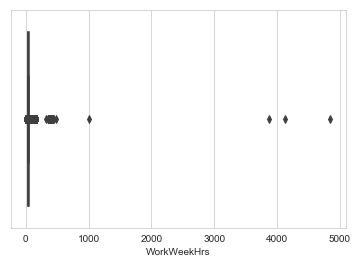

In [34]:
sns.boxplot(x=df['WorkWeekHrs'])
plt.savefig("viz/WorkWeekHrs", dpi=300, bbox_inches="tight")
plt.show()

Based on the box plot, it looks like there are some outliers in the data.

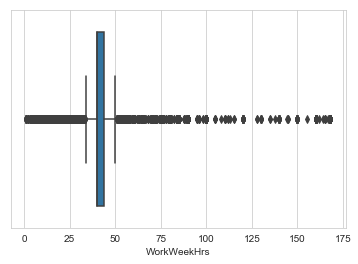

In [35]:
sns.boxplot(x=df[~(df['WorkWeekHrs'] > 24*7)]['WorkWeekHrs'])
plt.savefig("viz/WorkWeekHrs_drop_outliers", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
# Drop the work hours that are impossible
df = df[~(df['WorkWeekHrs'] > 24*7)]

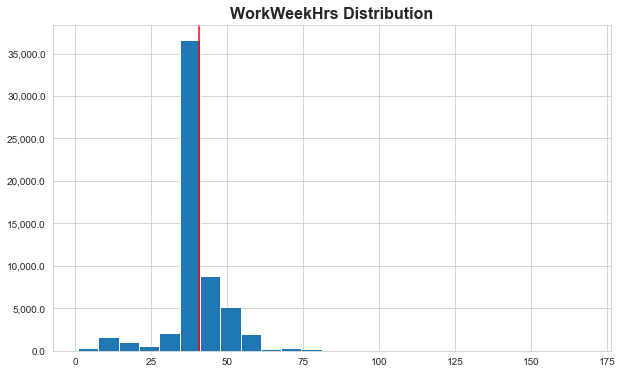

In [208]:
# Plot the distribution of WorkWeekHrs after dropping the outliers
f, ax = plt.subplots(figsize = (10,6))
df['WorkWeekHrs'].hist(bins=25)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,}'.format(y))) 
plt.axvline(x=df['WorkWeekHrs'].mean(), color = "red")
plt.title('WorkWeekHrs Distribution', fontsize=16, weight='bold')
plt.savefig("viz/WorkWeekHrs_drop_outliers_dist", dpi=300, bbox_inches="tight")
plt.show()

### 3.3. Exploratory Data Analysis - Categorical variables

In [38]:
df.select_dtypes(include=['object']).columns

Index(['Employment', 'Country', 'EdLevel', 'UndergradMajor', 'YearsCodePro',
       'MgrWant', 'OrgSize', 'CareerSat', 'DevType'],
      dtype='object')

In [39]:
# Create helper function to plot categorical variables
def plot_categorical_variables(col="", top_k=None, rotation=30):
    '''The function will plot 2 bar plots - one is the percentage of respondents by feature, 
                                            the other is WorkWeekHrs by feature
    
    Parameters: 
        col: a string of the feature name
        top_k: number of the top categories to plot
        rotation: number of the angle to rotate the xtick
    
    '''
    f, axes = plt.subplots(1, 2, figsize = (20,6))
    if top_k is not None:
        ax0=((df[col].value_counts()/len(df)).sort_values(ascending= False)[:top_k]).plot(kind='bar', ax=axes[0])
        ax0.set_title('Respondents by Top '+str(top_k)+' '+col, fontsize=16, weight='bold')
        top_k_list=(df[col].value_counts()/len(df)).sort_values(ascending= False)[:top_k].index
        ax1=sns.barplot(x=col, y="WorkWeekHrs", data=df[df[col].isin(top_k_list)], ax=axes[1], palette="Pastel1",
                        order=df[df[col].isin(top_k_list)][col].value_counts().index)
        ax1.set_title('WorkWeekHrs by Top '+str(top_k)+' '+col, fontsize=16, weight='bold')     
    else:
        ax0=((df[col].value_counts()/len(df)).sort_values(ascending= False)).plot(kind='bar', ax=axes[0])
        ax0.set_title('Respondents by '+col, fontsize=16, weight='bold')
        ax1=sns.barplot(x=col, y="WorkWeekHrs", data=df, ax=axes[1], palette="Pastel1",
                        order=df[col].value_counts().index)
        ax1.set_title('WorkWeekHrs by '+col, fontsize=16, weight='bold')
    
    ax0.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    ax0.set_ylabel("Percentage of the Respondents", fontsize=14)
    ax1.set_ylabel('WorkWeekHrs', fontsize=14)

    for i in range(len(axes)):
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        axes[i].set_xlabel(col, fontsize=14)
        axes[i].tick_params(axis='x', which='major', rotation=rotation)
    f.savefig("viz/"+col, dpi=300, bbox_inches="tight")
    plt.show()

### 3.3.1. Employment - Which of the following best describes your current employment status?

In [40]:
df['Employment'].value_counts()

Employed full-time                                      56040
Independent contractor, freelancer, or self-employed     5671
Employed part-time                                       2379
Name: Employment, dtype: int64

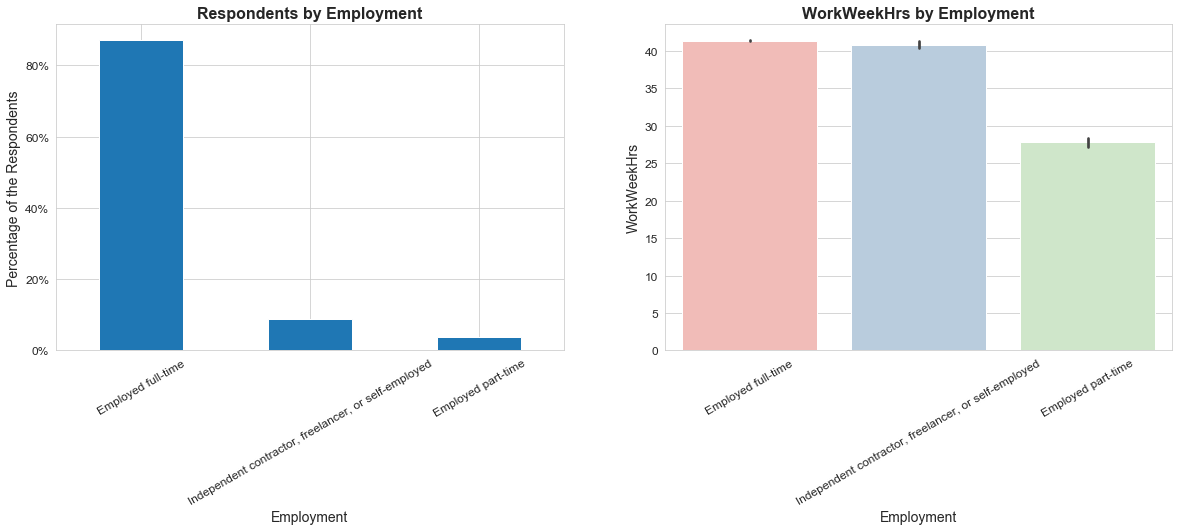

In [41]:
plot_categorical_variables(col="Employment")

### 3.3.2. Country - In which country do you currently reside?

In [42]:
df['Country'].value_counts()

United States                            16427
India                                     5570
United Kingdom                            4503
Germany                                   4352
Canada                                    2504
France                                    1776
Brazil                                    1544
Poland                                    1485
Australia                                 1448
Netherlands                               1393
Spain                                     1313
Russian Federation                        1282
Italy                                     1101
Sweden                                     994
Switzerland                                749
Israel                                     707
Ukraine                                    656
Turkey                                     595
Czech Republic                             564
Pakistan                                   554
Austria                                    551
Belgium      

In [43]:
len(set(df['Country']))

168

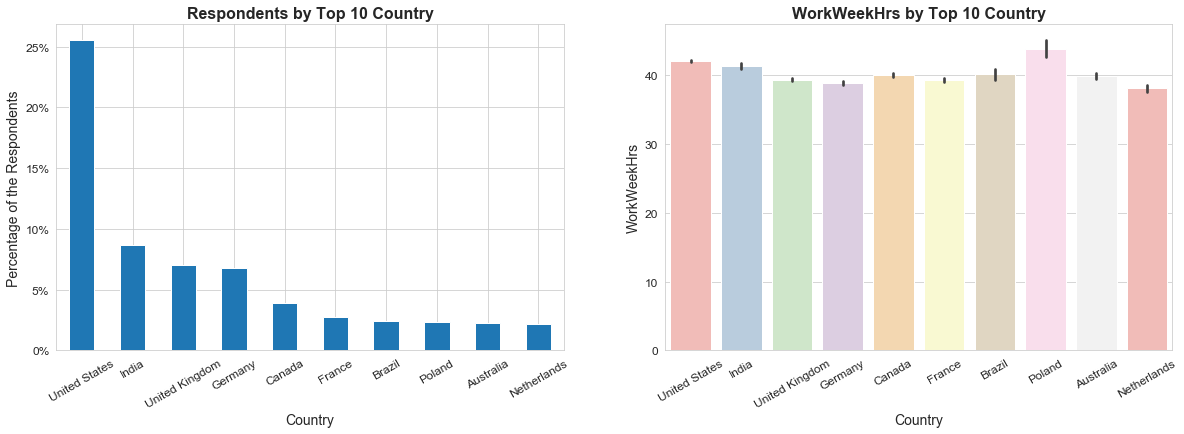

In [44]:
plot_categorical_variables(col="Country", top_k=10)

### 3.3.3 EdLevel - Which of the following best describes the highest level of formal education that you’ve completed?

In [45]:
df['EdLevel'].value_counts()

Bachelor’s degree (BA, BS, B.Eng., etc.)                                              31234
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           16026
Some college/university study without earning a degree                                 7303
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     3213
Associate degree                                                                       2113
Other doctoral degree (Ph.D, Ed.D., etc.)                                              1942
Professional degree (JD, MD, etc.)                                                      877
Primary/elementary school                                                               301
I never completed any formal education                                                  261
Name: EdLevel, dtype: int64

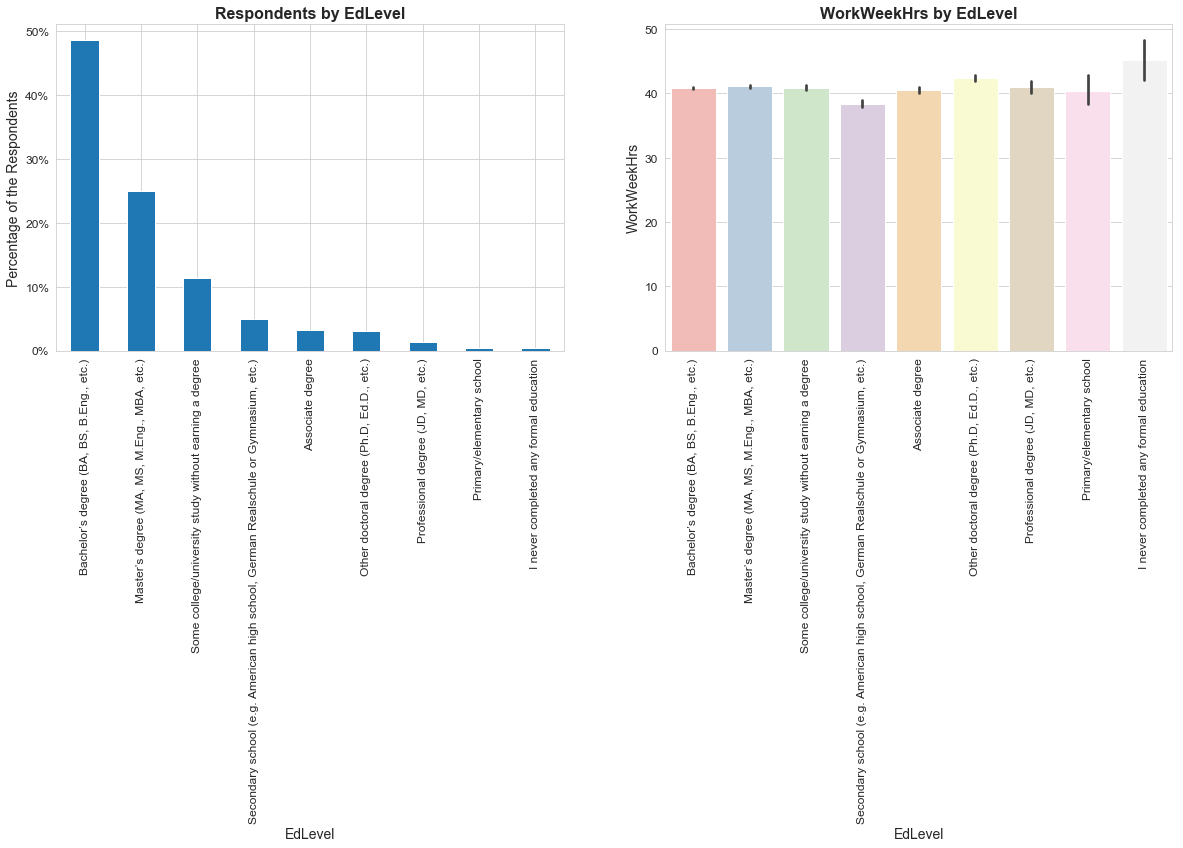

In [46]:
plot_categorical_variables(col="EdLevel", rotation=90)

### 3.3.4. UndergradMajor - What was your main or most important field of study?

In [47]:
df['UndergradMajor'].value_counts()

Computer science, computer engineering, or software engineering          37359
Another engineering discipline (ex. civil, electrical, mechanical)        4886
Information systems, information technology, or system administration     4059
A natural science (ex. biology, chemistry, physics)                       2592
Web development or web design                                             2404
Mathematics or statistics                                                 2308
A business discipline (ex. accounting, finance, marketing)                1328
A humanities discipline (ex. literature, history, philosophy)             1248
A social science (ex. anthropology, psychology, political science)        1044
Fine arts or performing arts (ex. graphic design, music, studio art)       978
I never declared a major                                                   644
A health science (ex. nursing, pharmacy, radiology)                        179
Name: UndergradMajor, dtype: int64

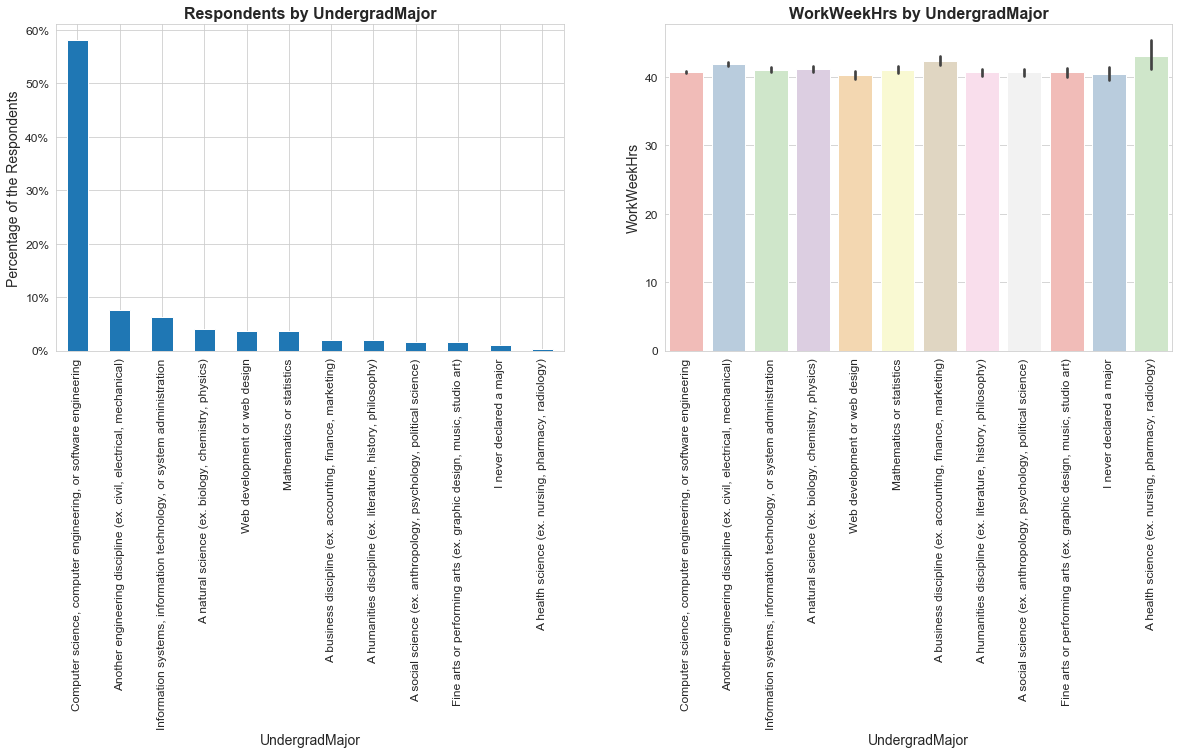

In [48]:
plot_categorical_variables(col="UndergradMajor", rotation=90)

### 3.3.5. YearsCodePro - How many years have you coded professionally (as a part of your work)?

In [49]:
df['YearsCodePro'].value_counts()

2                     6828
3                     6772
5                     5660
4                     5526
6                     4009
10                    3769
1                     3643
7                     3220
Less than 1 year      3110
8                     3034
12                    1963
15                    1813
9                     1765
20                    1748
11                    1479
13                    1247
18                    1034
14                     997
16                     679
19                     677
25                     601
22                     601
17                     552
21                     484
30                     449
23                     395
24                     279
28                     189
35                     183
26                     177
27                     169
32                     161
33                     114
29                     104
31                      99
34                      90
40                      89
3

In [50]:
len(set(df['YearsCodePro']))

53

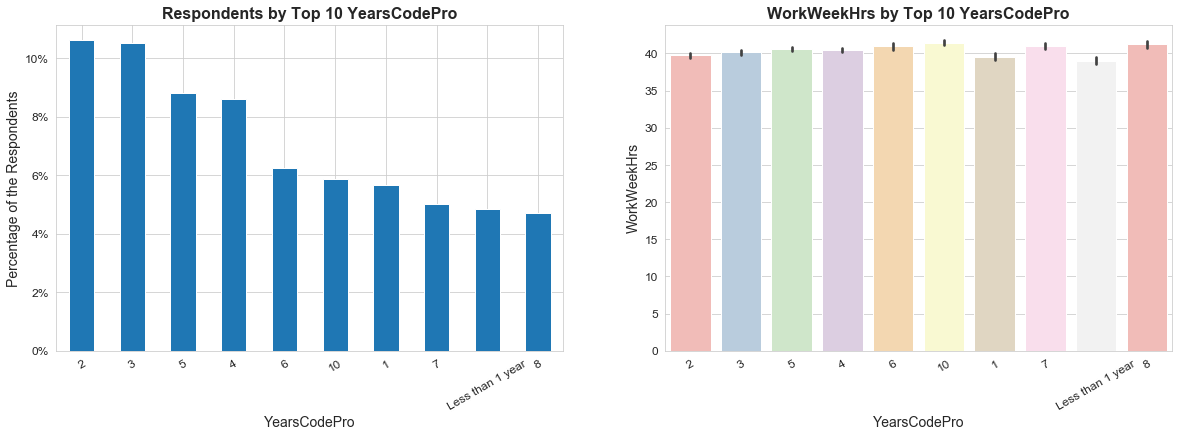

In [51]:
plot_categorical_variables(col="YearsCodePro", top_k=10)

### 3.3.6. MgrWant - Do you want to become a manager yourself in the future?

In [52]:
df['MgrWant'].value_counts()

Not sure                  20081
No                        18552
Yes                       13444
I am already a manager     2500
Name: MgrWant, dtype: int64

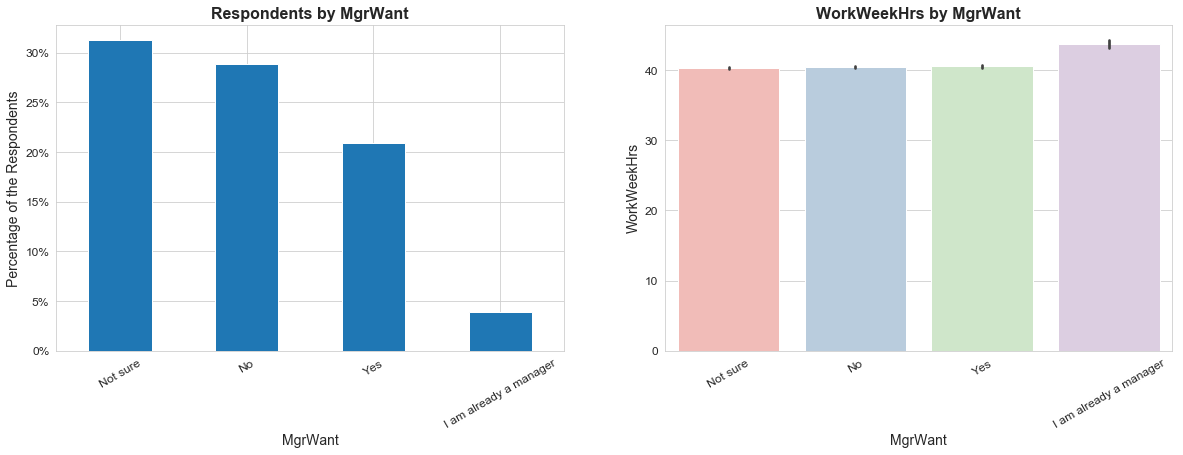

In [53]:
plot_categorical_variables(col="MgrWant")

### 3.3.7. OrgSize - Approximately how many people are employed by the company or organization you work for?

In [54]:
df['OrgSize'].value_counts()

20 to 99 employees                                    13655
100 to 499 employees                                  11491
10,000 or more employees                               8926
1,000 to 4,999 employees                               6673
2-9 employees                                          6345
10 to 19 employees                                     6010
500 to 999 employees                                   4076
Just me - I am a freelancer, sole proprietor, etc.     3004
5,000 to 9,999 employees                               2678
Name: OrgSize, dtype: int64

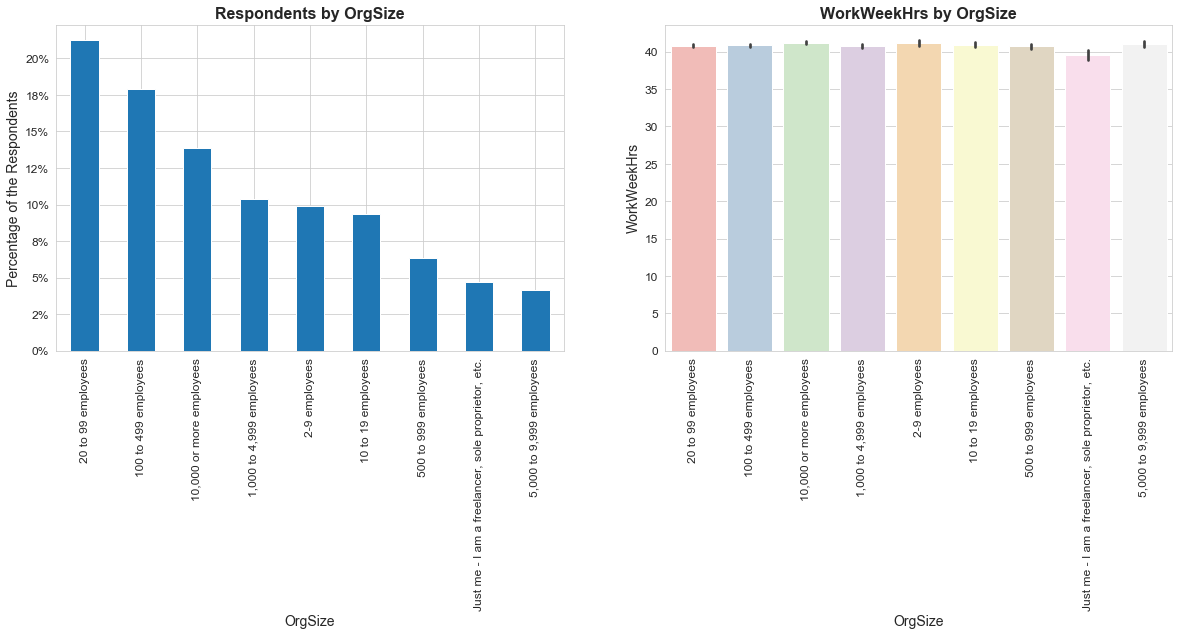

In [55]:
plot_categorical_variables(col="OrgSize", rotation=90)

### 3.3.8. CareerSat - Overall, how satisfied are you with your career thus far?

In [56]:
df['CareerSat'].value_counts()

Very satisfied                        26375
Slightly satisfied                    22332
Slightly dissatisfied                  6606
Neither satisfied nor dissatisfied     5858
Very dissatisfied                      3119
Name: CareerSat, dtype: int64

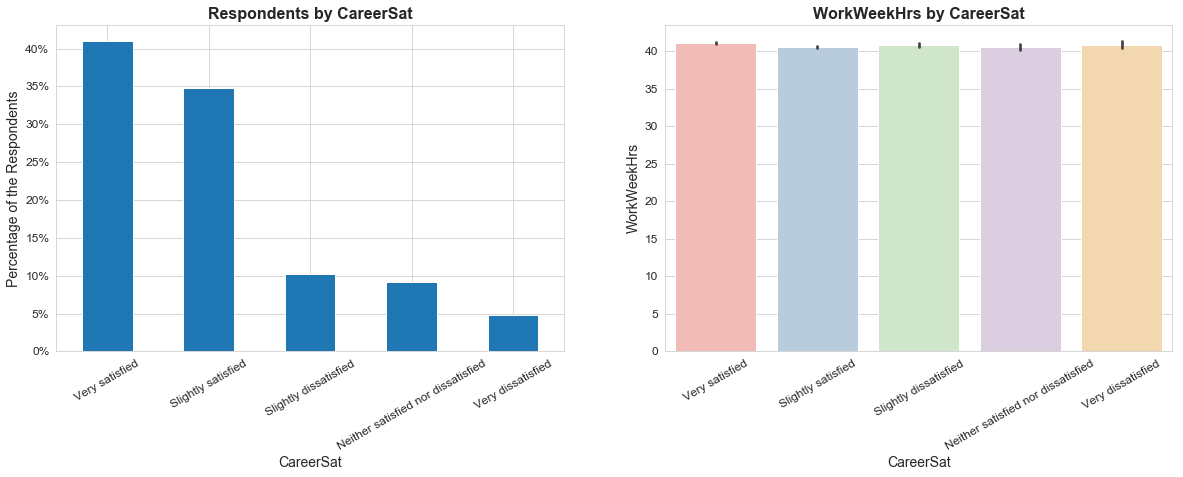

In [57]:
plot_categorical_variables(col="CareerSat")

### 3.3.9. DevType - Which of the following describe you? Please select all that apply.

In [58]:
df['DevType'].value_counts()

Developer, full-stack                                                                                                                                                                                                                                                                    7378
Developer, back-end                                                                                                                                                                                                                                                                      4273
Developer, back-end;Developer, front-end;Developer, full-stack                                                                                                                                                                                                                           2111
Developer, front-end                                                                                                                          

In [59]:
len(set(df['DevType']))

10398

The original values for DevType need to be parsed and cleaned.

In [60]:
# Clean 'DevType' and create dummy variables for each category
df['DevType_list'] = df['DevType'].apply(lambda x: x.split(';') if str(x)!='nan' else [])

In [61]:
# Convert the list of DevType to binary variables
devType_dummies = pd.get_dummies(df['DevType_list'].apply(pd.Series).stack()).sum(level=0)

In [62]:
len(devType_dummies.columns)

24

In [63]:
devType_dummies.head()

,Academic researcher,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices",...,Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Marketing or sales professional,Product manager,Scientist,Senior executive/VP,Student,System administrator
0,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
temp = devType_dummies.T

In [65]:
# On average, how many job title does one developer has?
temp.sum().sum()/len(temp.columns)

3.094325032351734

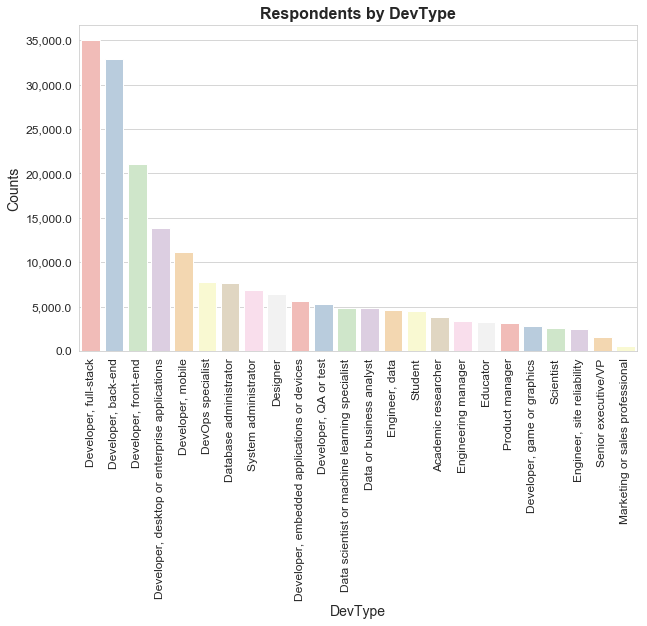

In [209]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize = (10,6))
sns.barplot(x=temp.index, y=temp.sum(axis=1), palette="Pastel1", order=temp.sum(axis=1).sort_values(ascending=False).index)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,}'.format(y))) 
ax.set_ylabel("Counts", fontsize=14)
ax.set_xlabel("DevType", fontsize=14)
ax.set_title("Respondents by DevType", fontsize=16, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', rotation=90)  
f.savefig("viz/DevType", dpi=300, bbox_inches="tight")
plt.show()

Based on the survey, full-stack, back-end, and front-end are the most common positions for developers.

In [67]:
df = pd.merge(df, devType_dummies, left_index=True, right_index=True).drop(['DevType', 'DevType_list'], axis=1)

### 3.4. Exploratory Data Analysis - Numerical variables

In [68]:
df.select_dtypes(include=['float']).columns

Index(['Age', 'ConvertedComp', 'WorkWeekHrs'], dtype='object')

In [69]:
# Correlation analysis
df[df.select_dtypes(include=['float']).columns].corr()

,Age,ConvertedComp,WorkWeekHrs
Age,1.000000,0.107447,0.070699
ConvertedComp,0.107447,1.000000,0.044781
WorkWeekHrs,0.070699,0.044781,1.000000


In [70]:
# Create helper function to plot numerical variables
def plot_numerical_variables(col="", rotation=0):
    '''The function will plot 2 plots - one is bar chart of counts by feature, 
                                        the other is scatter plot of WorkWeekHrs by feature
    
    Parameters: 
        col: a string of the feature name
        rotation: number of the angle to rotate the xtick
    
    '''
    f, axes = plt.subplots(1, 2, figsize = (20,6))
    ax0=df[col].hist(ax=axes[0])
    ax0.set_title(col+' Distribution', fontsize=16, weight='bold')
    ax1=sns.scatterplot(x=col, y="WorkWeekHrs", data=df, ax=axes[1])
    ax1.set_title(col+' vs. WorkWeekHrs', fontsize=16, weight='bold')
    
    ax0.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,}'.format(y))) 
    ax0.set_ylabel("Counts", fontsize=14)
    ax1.set_ylabel('WorkWeekHrs', fontsize=14)

    for i in range(len(axes)):
        axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,}'.format(x)))
        axes[i].set_xlabel(col, fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        axes[i].tick_params(axis='x', which='major', rotation=rotation)
    f.savefig("viz/"+col, dpi=300, bbox_inches="tight")
    plt.show()

### 3.4.1. Age - What is your age (in years)? 

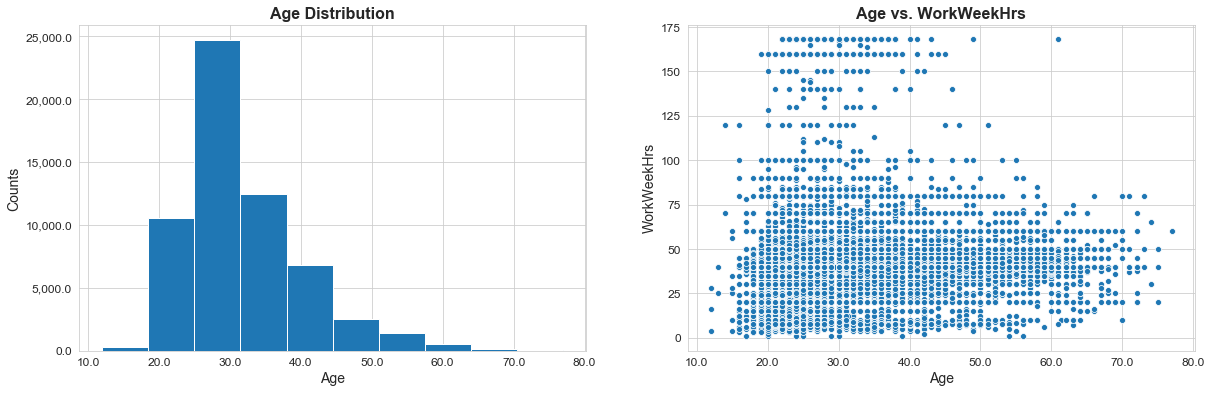

In [192]:
plot_numerical_variables(col="Age")

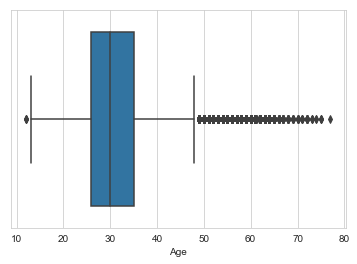

In [193]:
sns.boxplot(df['Age'])
plt.savefig("viz/Age_box", dpi=300, bbox_inches="tight")
plt.show()

In [73]:
len(df[(df['Age'] > 80) | (df['Age'] <10)])

30

In [74]:
# Remove Age outliers from the dataset
df = df[(df['Age'] < 80) & (df['Age'] > 10)]
# Reset index
df.reset_index(drop=True, inplace=True)

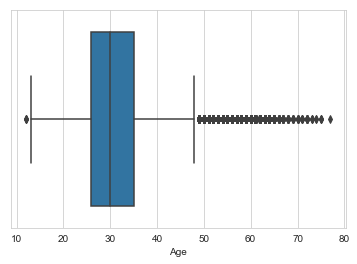

In [194]:
sns.boxplot(df['Age'])
plt.savefig("viz/Age_drop_outliers", dpi=300, bbox_inches="tight")
plt.show()

### 3.4.2. CovertedComp - Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.

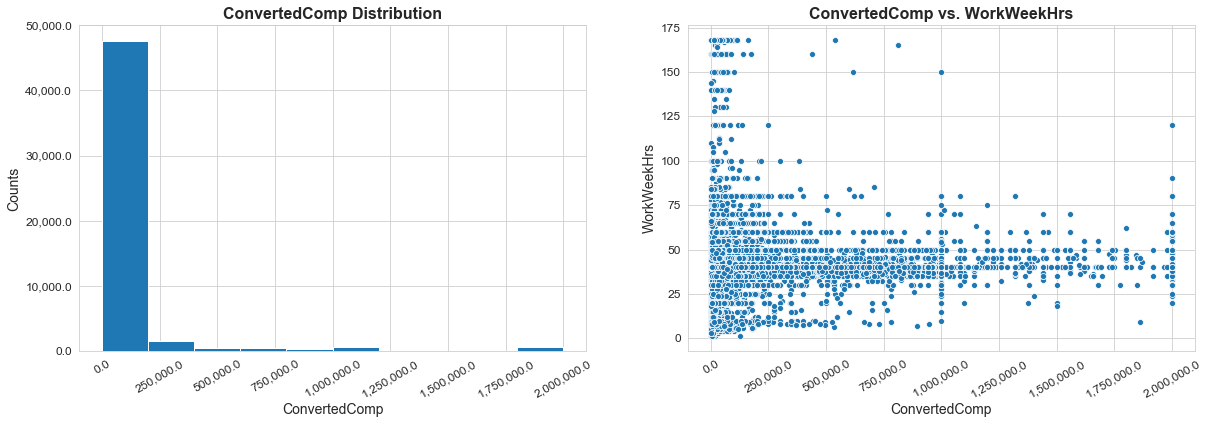

In [76]:
plot_numerical_variables(col="ConvertedComp", rotation=30)

### 3.5. Feature engineering

### 3.5.1. Covert categorical features to binary variables

In [77]:
df.select_dtypes(include=['object']).columns

Index(['Employment', 'Country', 'EdLevel', 'UndergradMajor', 'YearsCodePro',
       'MgrWant', 'OrgSize', 'CareerSat'],
      dtype='object')

In [78]:
# Keep the missing values while converting to binary variables
cat_dummies = pd.get_dummies(df[df.select_dtypes(include=['object']).columns], 
                             prefix=df.select_dtypes(include=['object']).columns,
                             dummy_na=True)

In [79]:
cat_dummies.shape

(59517, 266)

In [80]:
cat_dummies.head()

,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",Employment_nan,Country_Afghanistan,Country_Albania,Country_Algeria,Country_Andorra,Country_Angola,Country_Argentina,...,"OrgSize_5,000 to 9,999 employees",OrgSize_500 to 999 employees,"OrgSize_Just me - I am a freelancer, sole proprietor, etc.",OrgSize_nan,CareerSat_Neither satisfied nor dissatisfied,CareerSat_Slightly dissatisfied,CareerSat_Slightly satisfied,CareerSat_Very dissatisfied,CareerSat_Very satisfied,CareerSat_nan
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [81]:
df = pd.merge(df, cat_dummies, left_index=True, right_index=True).drop(df.select_dtypes(include=['object']).columns, 
                                                                       axis=1)

### 3.5.2. Impute missing values for `ConvertedComp`

In [85]:
df.isnull().sum()[df.isnull().sum() > 0]/len(df)

ConvertedComp    0.122604
dtype: float64

I chose to impute `ConvertedComp` with median instead of mean due to the outliers in the dataset.

In [91]:
# Impute na with median
df['ConvertedComp'].fillna((df['ConvertedComp'].median()), inplace=True)

In [93]:
# Make sure there are no missing values in the data
df.isnull().sum().sum()

0

### 3.5.3. Normalizing the features to [0, 1]

In [103]:
# 292 features in total
df.columns[df.columns != 'WorkWeekHrs']

Index(['Age', 'ConvertedComp', 'Academic researcher',
       'Data or business analyst',
       'Data scientist or machine learning specialist',
       'Database administrator', 'Designer', 'DevOps specialist',
       'Developer, QA or test', 'Developer, back-end',
       ...
       'OrgSize_5,000 to 9,999 employees', 'OrgSize_500 to 999 employees',
       'OrgSize_Just me - I am a freelancer, sole proprietor, etc.',
       'OrgSize_nan', 'CareerSat_Neither satisfied nor dissatisfied',
       'CareerSat_Slightly dissatisfied', 'CareerSat_Slightly satisfied',
       'CareerSat_Very dissatisfied', 'CareerSat_Very satisfied',
       'CareerSat_nan'],
      dtype='object', length=292)

In [105]:
# Apply MinMaxScaler to limit the range of values between 0 and 1
scaler = MinMaxScaler()
X = scaler.fit_transform(df[df.columns[df.columns != 'WorkWeekHrs']])

In [106]:
X

array([[0.24615385, 0.00441   , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15384615, 0.0305    , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.27692308, 0.0286435 , 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.33846154, 0.041244  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.38461538, 0.0343725 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.32307692, 0.0114575 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [107]:
X.shape

(59517, 292)

In [108]:
y = np.array(df['WorkWeekHrs'])

### 3.6. Train the model

In [110]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [111]:
# Start training the model with the default setting
regressor = DecisionTreeRegressor(random_state=0)  
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [184]:
print("r^2 with training data: {:.2f}".format(regressor.score(x_train, y_train)))

r^2 with training data: 1.00


In [185]:
print("r^2 with test data: {:.2f}".format(regressor.score(x_test, y_test)))

r^2 with test data: -0.79


The model could be overfitting the training dataset, so the R-squared is negative.

In [202]:
# Create helper function to plot the feature importances
def plot_feature_importances(model=None, top_k=len(df.columns[df.columns!='WorkWeekHrs']), viz_name=""):
    '''The function will plot the feature importance with its corresponding feature name
    
    Parameters: 
        model: a DecisionTreeRegressor object
        top_k: number of top feature to plot
    
    '''
    sns.set_style("whitegrid")
    axis_font = {'size':'15'}
    plt.figure(figsize = (10,8))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_k]
    plt.barh(range(top_k), importances[indices], align='center')
    plt.yticks(range(top_k), df.columns[df.columns != 'label'][indices], **axis_font)
    plt.title('Top {} Feature Importances'.format(top_k), **axis_font, weight='bold')
    plt.xlabel('Relative Importance', **axis_font)
    plt.savefig("viz/"+viz_name, dpi=300, bbox_inches="tight")
    plt.show()

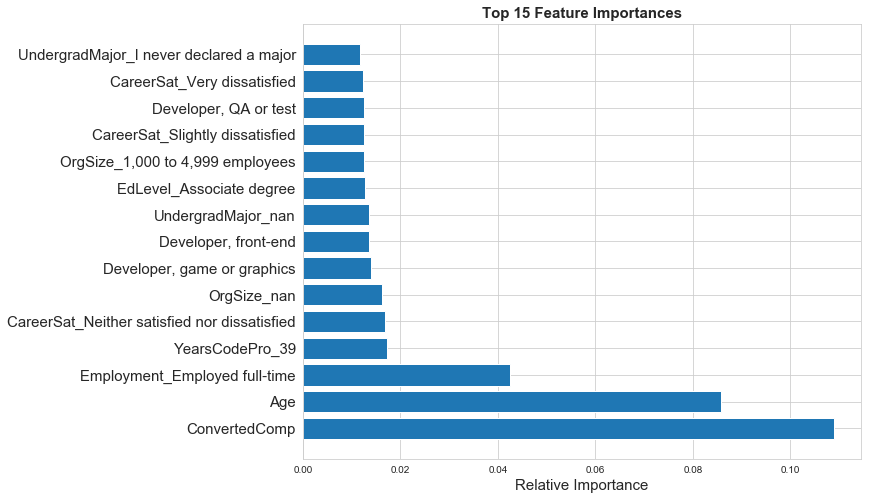

In [203]:
plot_feature_importances(regressor, 15, 'default_model')

In [191]:
# Conduct hyperparameters tuning and cross validation to prevent overfitting issue
params = {"max_depth": list(np.arange(5,30,5)), "min_samples_leaf": list(np.arange(50,300,50))}
clf = GridSearchCV(DecisionTreeRegressor(), params, cv=10)
clf.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 10, 15, 20, 25], 'min_samples_leaf': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [195]:
clf.best_params_

{'max_depth': 15, 'min_samples_leaf': 250}

In [196]:
clf.best_score_

0.06498669335700978

In [197]:
regressor_cv = clf.best_estimator_
regressor_cv.score(x_test, y_test)

0.07125425531475738

In [198]:
print("r^2 with test data: {:.2f}".format(regressor_cv.score(x_test, y_test)))

r^2 with test data: 0.07


The R-squared improved after tuning the hyperparameters - `max_depth` and `min_samples_leaf`

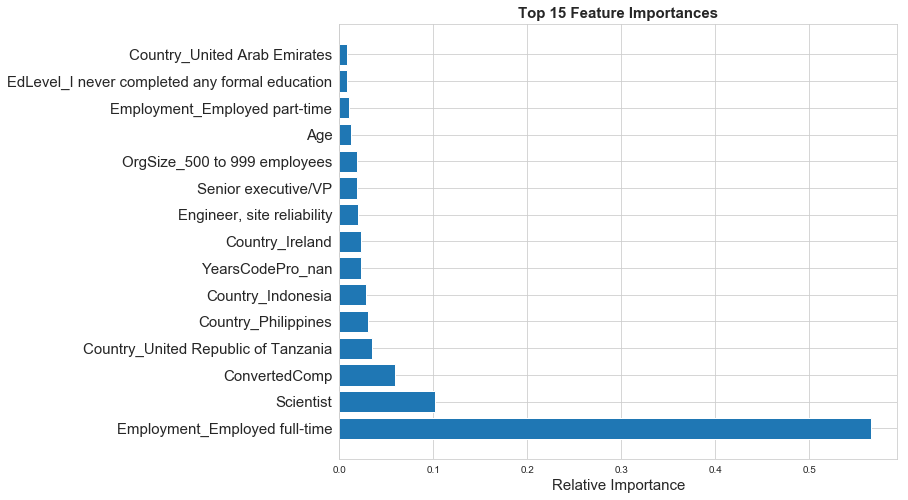

In [205]:
plot_feature_importances(model=regressor_cv, top_k=15, viz_name='tuned_model')

After tuning and cross validate the DecisionTreeRegressor model, we can see that the top 15 important features changed a lot from the base model. Now, the most important feature in terms of predicting `WorkWeekHrs` is whether the developer is employed full-time or not.

In [200]:
# Export the default tree to "tree_cv.dot"
export_graphviz(regressor_cv, 
                out_file ='viz/tree_cv.dot', 
                feature_names=list(df.columns[df.columns!='WorkWeekHrs']))

![tree_cv (1)](https://user-images.githubusercontent.com/35738148/83357057-0bd18d00-a338-11ea-8ec5-812d0ada6673.png)